In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = {
    "age" : [],
    "gender" : [],
    "race" : [],
    "date_time" : [],
    "file_name" : [],
}

directory_path = "./UTKFace/"

file_name = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
count = 0
for file in file_name:
    parts = file.split("_")
    if len(parts) != 4:
        continue
    try:
        data["age"].append(int(parts[0]))
        data["gender"].append(int(parts[1]))
        data["race"].append(int(parts[2]))
        data["date_time"].append((parts[3].split(".jpg.chip.jpg")[0]))
        data["file_name"].append(file)
        
    except ValueError:
        print(f"FILE {file} is Skipped")
        count = count + 1
        continue
        
        
df = pd.DataFrame(data)

In [3]:
df.shape

(23705, 5)

## For Performing Multiclass classification

In [4]:
def categorize_age(age):
    if age <= 14:
        return "Children"
    elif age <= 24:
        return "Teenagers"
    elif age <= 35:
        return "Young Adults"
    elif age <= 59:
        return "Adults"
    else:
        return "Seniors"
    
df["age_category"] = df["age"].apply(categorize_age)    

In [5]:
df["age_category"].value_counts()

Young Adults    8204
Adults          5910
Children        3651
Teenagers       3252
Seniors         2688
Name: age_category, dtype: int64

In [6]:
df["age_category"].value_counts(normalize = True)*100

Young Adults    34.608732
Adults          24.931449
Children        15.401814
Teenagers       13.718625
Seniors         11.339380
Name: age_category, dtype: float64

In [7]:
from tensorflow.keras.utils import Sequence
import cv2

class DataGenerator(Sequence):
    def __init__(self, df, batch_size = 32, dim = (224,224), n_channels = 3, shuffle = True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.labels = df[["age_category_encoded", "race_encoded", "gender_encoded"]].values
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        list_IDs_temp = [self.df.iloc[k].file_name for k in indexes]
        
        list_labels_temp = self.labels[indexes]
        
        X, y = self.__data_generation(list_IDs_temp, list_labels_temp)
        
        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self,list_IDs_temp, list_labels_temp):
        
        X = np.empty((self.batch_size, *self.dim, self.n_channels)) 
        y = np.empty((self.batch_size, ), dtype = int)
        
        for i, ID in enumerate(list_IDs_temp):
            
            img_path = os.path.join("./UTKFace", ID)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224,224))
            X[i, ] = img/255.0
            
            y[i] = list_labels_temp[i][0]
            
        return X, y

### Lossless compression

In [8]:
# for converting the categories into integer

age_mapping = {
    "Children" : 0,
    "Teenagers" : 1,
    "Young Adults" : 2,
    "Adults" : 3,
    "Seniors" : 4
}

race_mapping = {
    "White" : 0,
    "Black" : 1,
    "Asian" : 2,
    "Indian" : 3,
    "Others" : 4
}

gender_mapping = {
    "Male" : 0,
    "Female" : 1
}

reverse_age_mapping = {v:k for k,v in age_mapping.items()}
reverse_race_mapping = {v:k for k,v in race_mapping.items()}
reverse_gender_mapping = {v:k for k,v in gender_mapping.items()}

In [9]:
df["age_category_encoded"] = df["age_category"].map(age_mapping)
df["race_encoded"] = df["race"]
df["gender_encoded"] = df["gender"]

### for performing Train, Test and Validation we choosed

## Stratified Fold
to maintain the composition of the classes


#### 10,000 => 2000 (20%) cats , 8000 (80%) Dogs 

#### train and test split (70 and 30)


#### train(20% => cats && 80% => Dogs) == 1400 Cats && 5600 Dogs

#### test(20% => cats && 80% => Dogs) == 600 Cats && 2400 Dogs

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

df.reset_index(drop = True, inplace = True)

stratified_split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in stratified_split.split(df,df["age_category"]):
    train_df = df.loc[train_index]
    test_df = df.loc[test_index]
    
test_df.reset_index(drop = True, inplace  =True)

validation_split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.5, random_state = 42)

for test_index, valid_index in validation_split.split(test_df, test_df["age_category"]):
    test_df_final = test_df.loc[test_index]
    valid_df = test_df.loc[valid_index]
    
    
train_generator = DataGenerator(df = train_df, batch_size = 32, dim = (224,224), n_channels = 3, shuffle = True)
valid_generator = DataGenerator(df = valid_df, batch_size = 32, dim = (224,224), n_channels = 3, shuffle = True)
test_generator = DataGenerator(df = test_df_final, batch_size = 32, dim = (224,224), n_channels = 3, shuffle = False)

In [11]:
df["age_category"].value_counts(normalize = True)*100

Young Adults    34.608732
Adults          24.931449
Children        15.401814
Teenagers       13.718625
Seniors         11.339380
Name: age_category, dtype: float64

In [12]:
train_df["age_category"].value_counts(normalize = True)*100

Young Adults    34.607678
Adults          24.931449
Children        15.402869
Teenagers       13.720734
Seniors         11.337271
Name: age_category, dtype: float64

In [13]:
valid_df["age_category"].value_counts(normalize = True)*100

Young Adults    34.626740
Adults          24.926191
Children        15.394348
Teenagers       13.707296
Seniors         11.345424
Name: age_category, dtype: float64

In [14]:
test_df_final["age_category"].value_counts(normalize = True)*100

Young Adults    34.599156
Adults          24.936709
Children        15.400844
Teenagers       13.713080
Seniors         11.350211
Name: age_category, dtype: float64

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## This Time the Layers are unFrozen

### ? But why unfreeze 🤔

In [16]:
base_model = MobileNetV2(weights = "imagenet", include_top = False, input_shape = (224,224,3))

base_model.trainable = False

for layer in base_model.layers[-15:]: # unfreezing last 15 layers not all, to let them train
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(16, activation= "relu")(x)
x = Dense(16, activation= "relu")(x)
x = Dense(32, activation= "relu")(x)
x = Dense(64, activation= "relu")(x)
x = Dense(128, activation= "relu")(x)

num_age_categories = 5

predictions = Dense(num_age_categories, activation = "softmax")(x)

model = Model(inputs = base_model.input, outputs = predictions)

model.compile(optimizer = Adam(learning_rate = 0.0001), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

                                                                                                  
 block_3_expand_BN (BatchNo  (None, 56, 56, 144)          576       ['block_3_expand[0][0]']      
 rmalization)                                                                                     
                                                                                                  
 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)

                                                                                                  
 block_6_depthwise (Depthwi  (None, 14, 14, 192)          1728      ['block_6_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_p

                                                                    ']                            
                                                                                                  
 block_9_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_9_project[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_

 block_13_expand (Conv2D)    (None, 14, 14, 576)          55296     ['block_12_add[0][0]']        
                                                                                                  
 block_13_expand_BN (BatchN  (None, 14, 14, 576)          2304      ['block_13_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
          

 block_16_expand_relu (ReLU  (None, 7, 7, 960)            0         ['block_16_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_16_depthwise (Depthw  (None, 7, 7, 960)            8640      ['block_16_expand_relu[0][0]']
 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)     

In [17]:
history = model.fit(train_generator,
                   validation_data = valid_generator,
                   epochs = 5,
                   verbose = 1)

test_loss, test_accuracy = model.evaluate(test_generator, verbose = 1)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Epoch 1/5


592/592 [==============================] - 785s 1s/step - loss: 1.0799 - accuracy: 0.5327 - val_loss: 1.0997 - val_accuracy: 0.5473
Epoch 2/5
592/592 [==============================] - 680s 1s/step - loss: 0.8892 - accuracy: 0.6166 - val_loss: 1.0419 - val_accuracy: 0.5667
Epoch 3/5
592/592 [==============================] - 642s 1s/step - loss: 0.8371 - accuracy: 0.6355 - val_loss: 1.2204 - val_accuracy: 0.4468
Epoch 4/5
592/592 [==============================] - 677s 1s/step - loss: 0.8011 - accuracy: 0.6518 - val_loss: 0.9060 - val_accuracy: 0.6296
Epoch 5/5
74/74 [==============================] - 84s 1s/step - loss: 0.9228 - accuracy: 0.5942
Test Accuracy: 59.42%


### Insights:
* The fluctuating validation accuracy suggests that the model might be overfitting or struggling to generalize well to unseen data

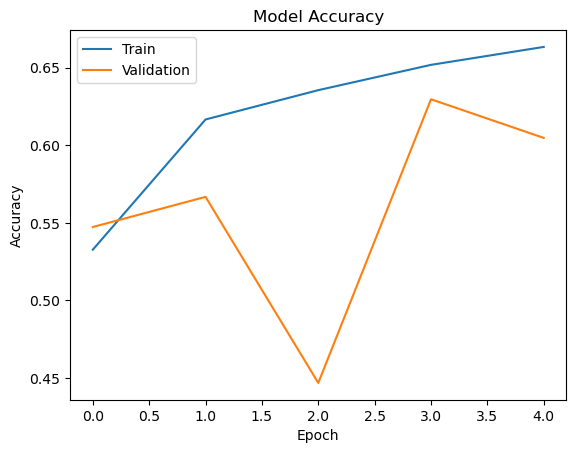

In [18]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()

* model's performance is sensitive to changes in the training data.

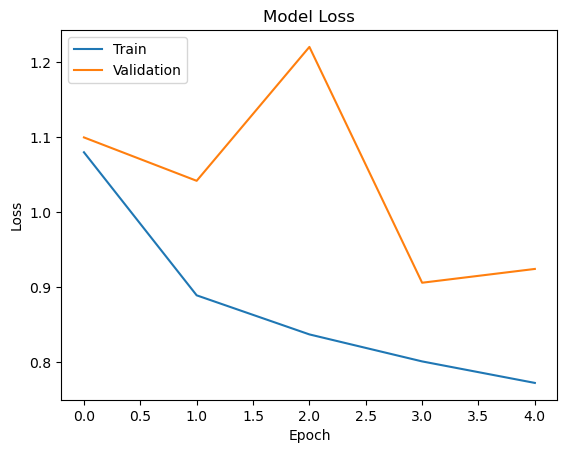

In [19]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()

In [22]:
y_true = []
y_pred_classes = []

for _,batch in enumerate(test_generator):
    images, labels = batch
    preds = model.predict(images)
    y_true.extend(labels)
    y_pred_classes.extend(np.argmax(preds, axis  = 1))
    
y_true = np.array(y_true)
y_pred_classes = np.array(y_pred_classes)


aligned_test_df = test_df_final.iloc[:len(y_true)]

1/1 [==============================] - 1s 929ms/step


* comparing model predictions against the true labels

In [23]:
from sklearn.metrics import classification_report

In [24]:
for race in aligned_test_df["race"].unique():
    for gender in aligned_test_df["gender"].unique(): 
        actual_race = reverse_race_mapping[race]
        actual_gender = reverse_gender_mapping[gender]
    
        subset_indices = aligned_test_df[(aligned_test_df["race"] == race) & (aligned_test_df["gender"] == gender) ].index
        valid_indices = subset_indices.intersection(range(len(y_true)))
        y_true_subset = y_true[valid_indices]
        y_pred_subset = y_pred_classes[valid_indices]
    
    
        print(f"classification report for Race : {actual_race}, Gender:  {actual_gender}")
        print(classification_report(y_true_subset, y_pred_subset, target_names = [reverse_age_mapping[i] for i in range(len(reverse_age_mapping))]))

classification report for Race : White, Gender:  Female
              precision    recall  f1-score   support

    Children       1.00      0.71      0.83        38
   Teenagers       0.29      0.33      0.31        36
Young Adults       0.58      0.71      0.64        94
      Adults       0.60      0.27      0.37        67
     Seniors       0.43      0.80      0.56        25

    accuracy                           0.55       260
   macro avg       0.58      0.57      0.54       260
weighted avg       0.59      0.55      0.55       260

classification report for Race : White, Gender:  Male
              precision    recall  f1-score   support

    Children       1.00      0.80      0.89        40
   Teenagers       0.44      0.38      0.41        32
Young Adults       0.67      0.84      0.74        97
      Adults       0.65      0.35      0.46        62
     Seniors       0.54      0.86      0.67        29

    accuracy                           0.66       260
   macro avg       0.

## ! Lets Move to next approch i.e. Age detection using Regression

In [1]:
from IPython.display import HTML
HTML('<img src="./giphy2.gif">')